# Ensemble Challenge (18-month Evaluation)

## Timepoint: July 19, 2021. 

## Setting: New York State upon the arrival of the Delta variant, vaccines available

### Load dependencies

In [1]:
import pandas as pd

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.result_processing import cdc_format

# Process data

In [2]:
location = "New York State"
# BETTER_NAMES = {'Cases': 'Infected',
#                 'Hospitalizations': 'Hospitalized',
#                 'Deaths': 'Dead'}
# ## instantiate, making sure no dates are skipped between start and end (could be found dynamically)
# full_dataset = pd.DataFrame({'date':pd.date_range(start='1/22/2020', end='3/29/2024')})

# ## fill the instantiated dataset
# for i in ['Cases','Hospitalizations','Deaths']:
#     all_data = pd.read_csv(f'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20{i}.csv')
#     subset   = all_data[all_data.location_name == location].groupby("date")["value"].sum().reset_index()
#     subset.date = pd.to_datetime(subset.date)
#     subset['cumsum'] = subset.value.cumsum()
#     full_dataset = full_dataset.merge(subset[['date','cumsum']], how='outer', on='date').rename(columns={'cumsum':BETTER_NAMES[i]})

# full_dataset[(full_dataset.date >= '2021-06-01') & (full_dataset.date < '2021-09-06')].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

## Save full dataset
# full_dataset.to_csv('full_dataset.csv', index=False)
full_dataset = pd.read_csv('full_dataset.csv')

## Define a function to select a subset of the data
def get_data_between(start='2021-06-01',end='2021-09-06'):
    return full_dataset[(full_dataset.date >= start) & (full_dataset.date < end)].reset_index(drop=True).reset_index(names=['Timestamp']).drop(['date'],axis=1)

### Define a function to process output to CDC format

In [3]:
def save_results_cdc_format(result, start_date, location):
    ensemble_data = cdc_format(
        result["ensemble_quantiles"],
        solution_string_mapping = {
            "infected_state": "cases",
            "hospitalized_state": "hosp.",
            "deceased_state": "death",
        },
        forecast_start_date=start_date,
        location=location,
        drop_column_names=[
            "timepoint_id",
            "number_days",
            "inc_cum",
            "output",
            "Forecast_Backcast",
        ],
        time_unit="days",
        train_end_point=10.,
    )
    return ensemble_data

### Define a function to plot results

In [4]:
def plot_results_and_data(results, data):
    # Plot the result for cumulative cases, hospitalizations, and deaths
    nice_labels={"deceased_state": "Deaths", "Cumulative_hosp_state": "Cumul Hosp", "Cumulative_cases_state": "Cumul Cases"}
    schema = plots.trajectories(results["data"], 
                                keep=["deceased_state", "Cumulative_hosp_state", "Cumulative_cases_state"], 
                                relabel=nice_labels,
                                points=data.drop(columns=['Timestamp']).reset_index(drop=True)
                               )
    # plots.save_schema(schema, "_schema.json")
    # plots.ipy_display(schema, dpi=150)
    return schema

def plot_all_results(results):
    # Plot the result for all state variables
    schema = plots.trajectories(results["data"], keep=".*_state")
    return schema

# Gather models

In [5]:
# See `Model_Kitchen.ipynb` for model derivation
model1 = "SEIRHD_age_structured_petrinet.json"
model2 = "SEIRHD_vacc_var_petrinet.json"
model3 = "SEIRHD_base_petrinet.json"
# model4 = "SEIRHD_time_varying_transmission_petrinet.json"

### Define solution mappings for each model

In [6]:
def solution_mapping(model_solution: dict) -> dict:
    # solution mapping for model1 and model2 and model3 (they all have the same set of observables)
    mapped_dict = {}
    mapped_dict["Susceptible"] = model_solution["susceptible"]
    mapped_dict["Exposed"] = model_solution["exposed"]
    mapped_dict["Infected"] = model_solution["infected"]
    mapped_dict["Recovered"] = model_solution["recovered"]
    mapped_dict["Hospitalized"] = model_solution["hospitalized"]
    mapped_dict["Deceased"] = model_solution["deceased"]
    mapped_dict["Cumulative_cases"] = model_solution["all_cases"]
    mapped_dict["Cumulative_hosp"] = model_solution["all_hosp"]
    return mapped_dict

### Set model paths and parameters for sampling

In [7]:
num_iterations = 300
num_samples = 100
start_time = 0.0
logging_step_size = 10.0

single_model_paths = [[model1], [model2], [model3]]
model_paths = [model1, model2, model3]

single_solution_mapping = [lambda x : x]
solution_mappings = [solution_mapping, solution_mapping, solution_mapping]

single_data_mapping = {'Infected': 'Cumulative_cases', 'Hospitalized': 'Cumulative_hosp', 'Dead': 'deceased'}
data_mapping = {'Infected': 'Cumulative_cases', 'Hospitalized': 'Cumulative_hosp', 'Dead': 'Deceased'}

# (1) Forecast 1: 07/19/2021 - 08/16/2021

In [8]:
dataset = get_data_between('2021-06-01', '2021-07-18')
end_time = len(dataset) + 29.0

## (A) Calibrate each model as an ensemble of a single model 

### Model 1

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 46 rows of data. The first column, Timestamp, begins at 0 and ends at 46. The subsequent columns are named: Infected, Hospitalized, Dead


,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_0/persistent_beta_param,model_0/persistent_r_EI_param,model_0/persistent_r_IR_y_param,model_0/persistent_r_IR_m_param,model_0/persistent_r_IH_y_param,model_0/persistent_r_IH_m_param,...,S_o_state,S_y_state,susceptible_state,exposed_state,infected_state,recovered_state,hospitalized_state,deceased_state,all_cases_state,all_hosp_state
0,0,0,10.0,1.0,0.000614,0.189043,0.475936,0.158656,0.021704,0.021172,...,3169882.75,3537636.25,17513032.0,718.717468,1406.368774,2107819.75,395.741333,53188.316406,2106449.50,137456.218750
1,1,0,20.0,1.0,0.000614,0.189043,0.475936,0.158656,0.021704,0.021172,...,3169870.75,3537620.00,17512940.0,141.823181,361.053467,2109546.75,168.033737,53224.171875,2107118.25,137634.375000
2,2,0,30.0,1.0,0.000614,0.189043,0.475936,0.158656,0.021704,0.021172,...,3169868.50,3537616.00,17512916.0,29.519575,83.795135,2110011.50,57.820290,53238.011719,2107252.75,137677.671875
3,3,0,40.0,1.0,0.000614,0.189043,0.475936,0.158656,0.021704,0.021172,...,3169868.50,3537615.50,17512914.0,6.315457,18.788530,2110130.50,17.738842,53242.492188,2107280.50,137687.468750
4,4,0,50.0,1.0,0.000614,0.189043,0.475936,0.158656,0.021704,0.021172,...,3169868.50,3537615.50,17512914.0,1.370285,4.162211,2110160.25,5.085543,53243.828125,2107287.75,137689.625000


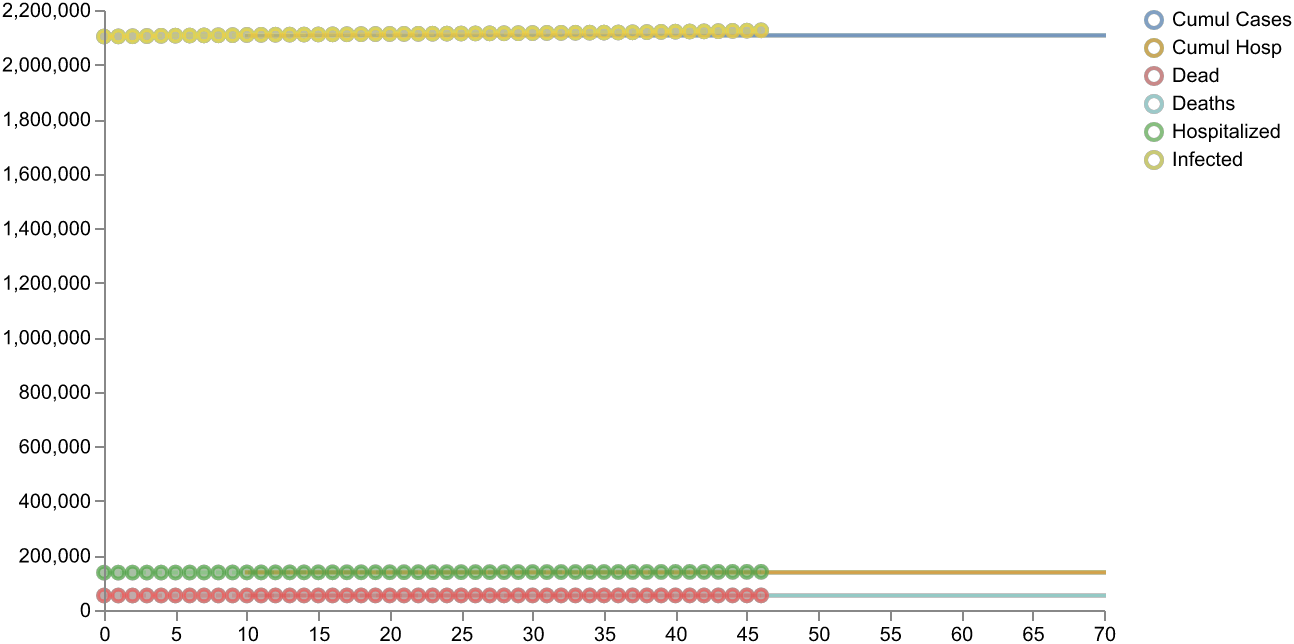

In [9]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[0], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[0], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

# ## Save results
# save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location).to_csv('ensemble1_forecast_0719.csv', index=False)

## Display results
display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Model 2

In [10]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)


## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location).to_csv('ensemble1_forecast_0719.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 46 rows of data. The first column, Timestamp, begins at 0 and ends at 46. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


### Model 3

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 46 rows of data. The first column, Timestamp, begins at 0 and ends at 46. The subsequent columns are named: Infected, Hospitalized, Dead


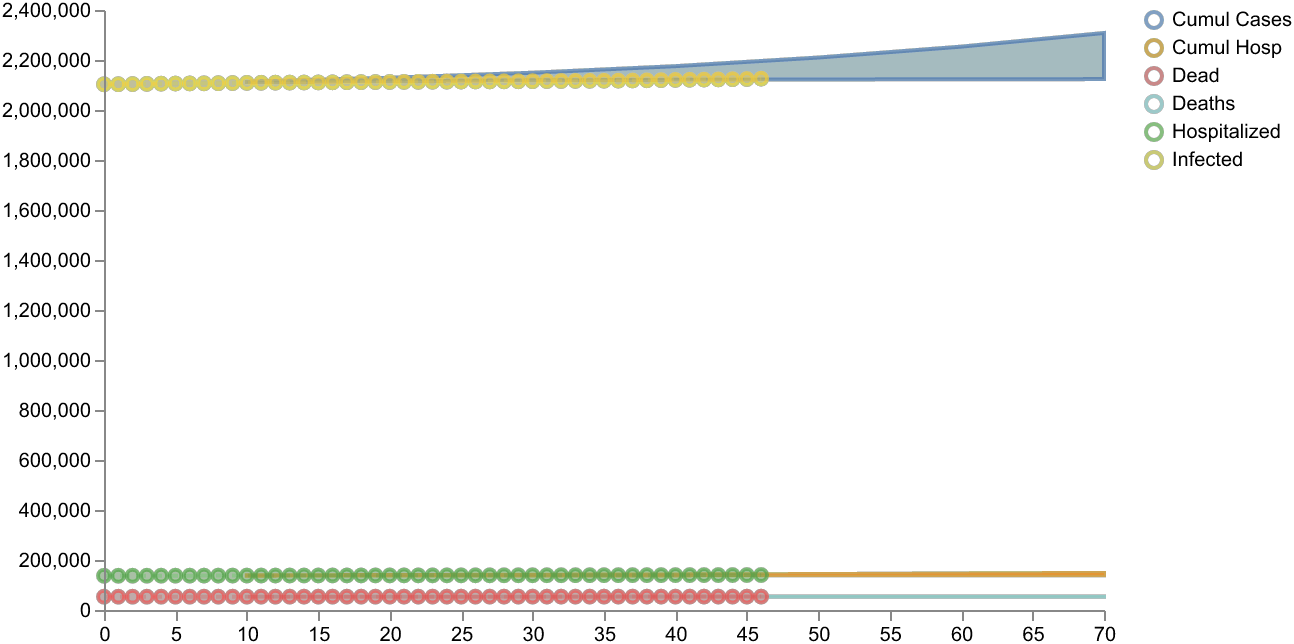

In [11]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[2], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[2], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
# save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location).to_csv('ensemble1_forecast_0719.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## (B) Calibrate an ensemble of multiple models

In [12]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-19", location).to_csv('ensemble3_forecast_0719.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 46 rows of data. The first column, Timestamp, begins at 0 and ends at 46. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


# (2) Forecast 2: 07/26/2021 - 08/23/2021

In [13]:
dataset = get_data_between('2021-06-01', '2021-07-25')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [14]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-26", location).to_csv('ensemble1_forecast_0726.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 53 rows of data. The first column, Timestamp, begins at 0 and ends at 53. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


## (B) Calibrate an ensemble of multiple models

In [15]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-07-26", location).to_csv('ensemble3_forecast_0726.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 53 rows of data. The first column, Timestamp, begins at 0 and ends at 53. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


# (3) Forecast 3: 08/02/2021 - 08/30/2021

In [16]:
dataset = get_data_between('2021-06-01', '2021-08-01')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [17]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-02", location).to_csv('ensemble1_forecast_0802.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 60 rows of data. The first column, Timestamp, begins at 0 and ends at 60. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


## (B) Calibrate an ensemble of multiple models

In [18]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-02", location).to_csv('ensemble3_forecast_0802.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 60 rows of data. The first column, Timestamp, begins at 0 and ends at 60. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


# (4) Forecast 4: 08/09/2021 - 09/06/2021

In [19]:
dataset = get_data_between('2021-06-01', '2021-08-08')
end_time = len(dataset) + 29.0

## (A) Calibrate an ensemble of a single model

In [20]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(single_model_paths[1], single_solution_mapping, dataset, 
                                                 data_mapping=single_data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
calibrated_ensemble_result = pyciemss.ensemble_sample(single_model_paths[1], single_solution_mapping, 
                                                      end_time, logging_step_size, num_samples, 
                                                      start_time=start_time, inferred_parameters=parameter_estimates)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-09", location).to_csv('ensemble1_forecast_0809.csv', index=False)

## Display results
# display(calibrated_ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 67 rows of data. The first column, Timestamp, begins at 0 and ends at 67. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(


## (B) Calibrate an ensemble of multiple models

In [21]:
## Calibrate the model to data
calibrated_results = pyciemss.ensemble_calibrate(model_paths, solution_mappings, dataset, 
                                                 data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
# print(parameter_estimates())

## Sample the calibrated model
ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, 
                                           logging_step_size, num_samples, start_time=start_time)

## Save results
save_results_cdc_format(calibrated_ensemble_result, "2021-08-09", location).to_csv('ensemble3_forecast_0809.csv', index=False)

## Display results
# display(ensemble_result['data'].head())
schema = plot_results_and_data(calibrated_ensemble_result, dataset)
# schema = plot_all_results(calibrated_ensemble_result)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 67 rows of data. The first column, Timestamp, begins at 0 and ends at 67. The subsequent columns are named: Infected, Hospitalized, Dead


/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/result_processing.py:312: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  q_ensemble_data["forecast_date"] = pd.to_datetime(
